In [4]:
import mne
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


Filtro de (0.3, 50)

In [63]:
# Let's load a nap recording, directly as an MNE Raw object
raw = mne.io.read_raw_edf('data/10/10.edf', preload=True, verbose=False)

raw.resample(100)
raw.filter(0.3, 45)

print('The channels are:', raw.ch_names)
print('The sampling frequency is:', raw.info['sfreq'])

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 47.50 Hz)
- Filter length: 1101 samples (11.010 sec)

The channels are: ['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8']
The sampling frequency is: 100.0


In [84]:
#Eliminamos las ultimas 30 epochs de 30 segundos ya que en el informe inicial creen conveniente hacerlo.
data = raw.get_data() * 1e6
print(data.shape)
data = data[:,:-30*30]
print(data.shape)

(19, 2388000)
(19, 2387100)


In [85]:
#raw.drop_channels(['ROC-A1', 'LOC-A2', 'EMG1-EMG2', 'EKG-R-EKG-L'])
chan = raw.ch_names
print(chan)

['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8']


In [86]:
sf = raw.info['sfreq']
sf

100.0

In [87]:
# Let's now load the human-scored hypnogram, where each value represents a 30-sec epoch.
hypno = np.loadtxt('data/10/10_1.txt', dtype=str)


#W=0
#N1=1
#N2=2
#N3=3
#R=5   

In [88]:
#Con esta funcion homogeneizamos para que el numero 5(fase REM) sea 4.

def tagHomo(taglist):
    replacement = {
        "5":"4"
    }
    #out = np.array([replacement[i] for i in taglist])
    out = [int(4) if i == "5" else int(i) for i in taglist]
    return out
hypno = tagHomo(hypno)

<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

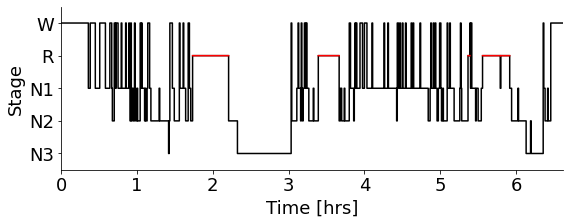

In [89]:
import yasa
yasa.plot_hypnogram(hypno)

In [90]:
yasa.sleep_statistics(hypno, sf_hyp=1/30)

{'TIB': 398.0,
 'SPT': 366.0,
 'WASO': 41.5,
 'TST': 324.5,
 'N1': 110.5,
 'N2': 90.5,
 'N3': 56.0,
 'REM': 67.5,
 'NREM': 257.0,
 'SOL': 22.0,
 'Lat_N1': 22.0,
 'Lat_N2': 41.0,
 'Lat_N3': 85.5,
 'Lat_REM': 104.5,
 '%N1': 34.05238828967642,
 '%N2': 27.889060092449924,
 '%N3': 17.257318952234208,
 '%REM': 20.801232665639446,
 '%NREM': 79.19876733436055,
 'SE': 81.53266331658291,
 'SME': 88.66120218579235}

In [91]:
counts, probs = yasa.transition_matrix(hypno)
probs.round(3)

To Stage,0,1,2,3,4
From Stage,,,,,
0,0.671,0.315,0.014,0.000,0.000
1,0.149,0.697,0.145,0.000,0.009
2,0.066,0.105,0.790,0.022,0.017
3,0.018,0.000,0.018,0.964,0.000
4,0.007,0.015,0.015,0.000,0.963


In [92]:
np.diag(probs.loc[2:, 2:]).mean().round(3)

0.906

In [93]:
hypno_up = yasa.hypno_upsample_to_data(hypno, sf_hypno=1/30, data=raw)
print(len(hypno_up))

2388000


In [94]:
yasa.plot_spectrogram(data[chan.index("C4-A1")], sf, hypno_up);

AssertionError: Hypno must have the same sf as data.

In [95]:
yasa.bandpower(raw)

,Delta,Theta,Alpha,Sigma,Beta,Gamma,TotalAbsPow,FreqRes,Relative
Chan,,,,,,,,,
LOC-A2,0.666434,0.159817,0.078749,0.041584,0.047203,0.006213,6.352204e-01,0.25,True
ROC-A1,0.674586,0.145444,0.070820,0.044844,0.058030,0.006276,6.970479e-01,0.25,True
F3-A2,0.655987,0.185820,0.076412,0.036353,0.040171,0.005256,8.453458e-01,0.25,True
C3-A2,0.635300,0.193715,0.082078,0.040905,0.042537,0.005465,8.076791e-01,0.25,True
O1-A2,0.597744,0.209185,0.097122,0.046417,0.044275,0.005257,6.338405e-01,0.25,True
F4-A1,0.657623,0.171992,0.073290,0.040831,0.050205,0.006058,8.516351e-01,0.25,True
C4-A1,0.620405,0.181342,0.085091,0.048960,0.057299,0.006903,7.055986e-01,0.25,True
O2-A1,0.572636,0.203618,0.106210,0.055261,0.055192,0.007084,5.694610e-01,0.25,True
X1,0.000013,0.009062,0.045099,0.092208,0.524484,0.329134,5.239661e-02,0.25,True


In [96]:
yasa.bandpower(raw, relative=False, bands=[(1, 9, "Slow"), (9, 30, "Fast")])

,Slow,Fast,TotalAbsPow,FreqRes,Relative
Chan,,,,,
LOC-A2,3.894476e-01,8.900756e-02,4.784552e-01,0.25,False
ROC-A1,4.215583e-01,1.045347e-01,5.260929e-01,0.25,False
F3-A2,5.913467e-01,1.060905e-01,6.974371e-01,0.25,False
C3-A2,5.683214e-01,1.094793e-01,6.778007e-01,0.25,False
O1-A2,4.323254e-01,9.604818e-02,5.283736e-01,0.25,False
F4-A1,5.782971e-01,1.182563e-01,6.965534e-01,0.25,False
C4-A1,4.766991e-01,1.141216e-01,5.908207e-01,0.25,False
O2-A1,3.776526e-01,1.016606e-01,4.793132e-01,0.25,False
X1,8.445208e-04,3.430655e-02,3.515107e-02,0.25,False


In [97]:
bandpower = yasa.bandpower(raw, hypno=hypno_up, include=(2, 3, 4))

In [98]:
#fig = yasa.topoplot(bandpower.xs(3)['Delta'])

Detección de splindles

In [99]:
sp = yasa.spindles_detect(raw, hypno=hypno_up, include=(2, 3))

04-May-22 13:41:09 | ERROR | Wrong data amplitude for X3 (trimmed STD = 0.037). Unit of data MUST be uV! Channel will be skipped.
04-May-22 13:41:09 | ERROR | Wrong data amplitude for SaO2 (trimmed STD = 361690.528). Unit of data MUST be uV! Channel will be skipped.
04-May-22 13:41:40 | WARNING | No spindle were found in channel X2.
04-May-22 13:41:46 | WARNING | No spindle were found in channel X6.
04-May-22 13:41:54 | WARNING | No spindle were found in channel DC8.


In [100]:
sp.summary()

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Stage,Channel,IdxChannel
0,4464.31,4464.75,4465.13,0.82,3.430674,0.636995,-0.559365,0.323115,12.816079,10.0,0.530120,2,LOC-A2,0
1,4580.56,4580.98,4581.07,0.51,3.804446,0.831030,-0.264892,0.300588,12.790071,6.0,0.807692,2,LOC-A2,0
2,4664.59,4664.99,4665.18,0.59,3.214776,0.661100,-0.497891,0.274572,13.022398,8.0,0.666667,2,LOC-A2,0
3,4971.64,4972.14,4972.38,0.74,3.156897,0.719983,-0.232832,0.444876,12.638993,9.0,0.666667,2,LOC-A2,0
4,5025.75,5026.11,5026.28,0.53,2.292854,0.510270,-0.705727,0.279748,13.666018,6.0,0.666667,2,LOC-A2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,23261.67,23261.94,23262.30,0.63,466.226027,70.104507,3.192950,0.274362,12.561690,8.0,0.421875,2,X8,16
2971,23263.75,23263.99,23264.37,0.62,397.859317,55.785805,3.155295,0.304670,12.842402,7.0,0.380952,2,X8,16
2972,23265.55,23266.01,23266.39,0.84,538.069938,65.739105,2.799659,0.371836,12.749370,10.0,0.541176,2,X8,16
2973,23269.48,23270.01,23270.33,0.85,676.662492,84.711533,3.001260,0.322350,12.570392,10.0,0.616279,2,X8,16


The documentation of the function explains what each of these columns represent and how they’re calculated. Furthermore, by specifying the grp_chan and grp_stage parameters, we tell YASA to first average across channels and slep stages, respectively:

In [101]:
sp.summary(grp_chan=True, grp_stage=True)

Count   Density  Duration   Amplitude         RMS  AbsPower  \
Stage Channel                                                                
2     C3-A2      116  1.281768  0.809310    4.971974    1.081575 -0.004177   
      C4-A1       97  1.071823  0.836598    4.924498    1.041050 -0.084912   
      DC3        226  2.497238  0.640177  731.797543  103.227438  3.382710   
      F3-A2       45  0.497238  0.727556    4.731760    1.016887 -0.076305   
      F4-A1       44  0.486188  0.765682    4.975400    1.066435 -0.033394   
      LOC-A2       9  0.099448  0.606667    2.885209    0.639356 -0.458943   
      O1-A2      241  2.662983  0.983983    4.754050    1.029437 -0.022287   
      O2-A1      160  1.767956  0.888625    4.279158    0.900659 -0.178992   
      ROC-A1      17  0.187845  0.733529    4.178824    0.849604 -0.294056   
      X1           4  0.044199  0.612500    2.173360    0.356068 -1.201635   
      X4           1  0.011050  0.570000   16.371406    2.545886  0.132941   
      X5         135  1.491713  0.966000   17.411217    2.967240  0.323893   
      X7         567  6.265193  0.607672   72.081345   10.386514  1.566095   
      X8         613  6.773481  0.599445  362.984101   52.700255  3.007272   
3     C3-A2       27  0.482143  0.874815    5.488477    1.171053  0.023877   
      C4-A1       27  0.482143  0.679259    3.869574    0.884902 -0.201949   
      DC3        183  3.267857  0.623989  602.425700   84.477136  3.361302   
      F3-A2       10  0.178571  0.718000    4.982290    1.078674  0.003739   
      F4-A1        7  0.125000  0.721429    4.034281    0.905523 -0.168114   
      O1-A2       65  1.160714  0.963846    4.856671    1.055179 -0.009577   
      O2-A1       42  0.750000  0.812381    4.011828    0.883502 -0.199754   
      ROC-A1       2  0.035714  0.685000    2.605878    0.622843 -0.419129   
      X5          24  0.428571  0.925000    4.902409    0.899111 -0.217947   
      X7          88  1.571429  0.616023   87.574925   12.594758  1.695415   
      X8         225  4.017857  0.618578  529.443779   75.615599  3.213500   

               RelPower  Frequency  Oscillations  Symmetry  
Stage Channel                                               
2     C3-A2    0.353338  13.382579     10.387931  0.460023  
      C4-A1    0.330315  13.380664     10.608247  0.501296  
      DC3      0.318365  12.748756      7.862832  0.441821  
      F3-A2    0.321014  13.083442      9.044444  0.507732  
      F4-A1    0.317519  13.004053      9.454545  0.492092  
      LOC-A2   0.313515  13.116510      7.666667  0.587289  
      O1-A2    0.409099  13.552014     12.929461  0.489877  
      O2-A1    0.355413  13.428200     11.368750  0.493833  
      ROC-A1   0.271049  12.671197      8.588235  0.559013  
      X1       0.321629  13.978958      8.250000  0.567573  
      X4       0.239333  13.733808      5.000000  0.913793  
      X5       0.323279  13.485312     11.548148  0.475480  
      X7       0.316836  12.719910      7.509700  0.501514  
      X8       0.316194  12.734538      7.352365  0.478425  
3     C3-A2    0.338874  13.448312     11.444444  0.504878  
      C4-A1    0.289712  13.423621      8.666667  0.424911  
      DC3      0.336393  12.783282      7.726776  0.350956  
      F3-A2    0.322967  13.302221      9.100000  0.561944  
      F4-A1    0.289474  13.084233      9.142857  0.467467  
      O1-A2    0.370559  13.582273     12.661538  0.440428  
      O2-A1    0.319768  13.506274     10.642857  0.477201  
      ROC-A1   0.298225  12.673489      8.500000  0.570464  
      X5       0.464635  13.372907     11.416667  0.608712  
      X7       0.311935  12.727129      7.602273  0.501613  
      X8       0.311804  12.782859      7.662222  0.458568

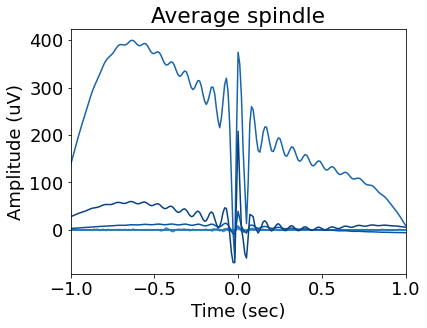

In [102]:
# Because of the large number of channels, we disable the 95%CI and legend
sp.plot_average(ci=None, legend=False, palette="Blues");

Slow-Waves

In [103]:
sw = yasa.sw_detect(raw, hypno=hypno_up, include=(2, 3))
sw.summary()

04-May-22 13:41:57 | ERROR | Wrong data amplitude for X3 (trimmed STD = 0.037). Unit of data MUST be uV! Channel will be skipped.
04-May-22 13:41:57 | ERROR | Wrong data amplitude for SaO2 (trimmed STD = 361690.528). Unit of data MUST be uV! Channel will be skipped.
04-May-22 13:41:59 | WARNING | No SW were found in channel LOC-A2.
04-May-22 13:41:59 | WARNING | No SW were found in channel ROC-A1.
04-May-22 13:41:59 | WARNING | No SW were found in channel F3-A2.
04-May-22 13:41:59 | WARNING | No SW were found in channel C3-A2.
04-May-22 13:42:00 | WARNING | No SW were found in channel O1-A2.
04-May-22 13:42:00 | WARNING | No SW were found in channel F4-A1.
04-May-22 13:42:00 | WARNING | No SW were found in channel C4-A1.
04-May-22 13:42:00 | WARNING | No SW were found in channel O2-A1.
04-May-22 13:42:00 | WARNING | No SW were found in channel X1.
04-May-22 13:42:00 | WARNING | No SW were found in channel X2.
04-May-22 13:42:00 | WARNING | No SW were found in channel X5.
04-May-22 13:4

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,Stage,Channel,IdxChannel
0,23232.06,23232.35,23232.67,23233.20,23233.51,1.45,-42.385232,46.007891,88.393123,276.228508,0.689655,2,X4,11
1,2480.41,2480.71,2480.96,2481.15,2481.73,1.32,-74.352895,34.004450,108.357345,433.429378,0.757576,2,DC3,14
2,2489.32,2489.57,2489.74,2489.85,2489.92,0.60,-83.029012,40.264546,123.293558,725.256222,1.666667,2,DC3,14
3,2506.40,2507.42,2507.55,2507.73,2507.85,1.45,-58.057204,103.545979,161.603182,1243.101403,0.689655,2,DC3,14
4,3577.00,3577.26,3577.49,3577.67,3578.33,1.33,-135.201591,74.860348,210.061939,913.312777,0.751880,2,DC3,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,11073.18,11073.89,11074.23,11074.48,11074.80,1.62,-195.376716,141.143985,336.520700,989.766766,0.617284,2,X8,16
58,13466.51,13466.81,13467.26,13467.84,13468.24,1.73,-107.043360,79.956789,187.000150,415.555889,0.578035,2,X8,16
59,13650.93,13651.37,13652.00,13652.47,13652.72,1.79,-143.988638,131.013729,275.002367,436.511693,0.558659,2,X8,16
60,18758.12,18758.75,18759.06,18759.32,18759.57,1.45,-111.154818,104.618785,215.773603,696.043880,0.689655,2,X8,16


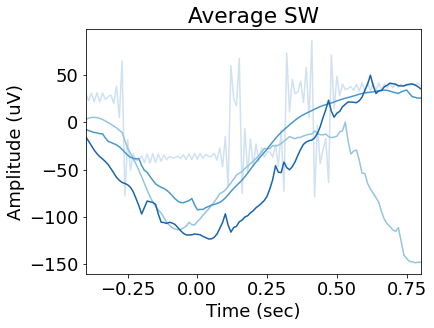

In [104]:
sw.plot_average(ci=None, legend=False, palette="Blues");

C:\Users\franc\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


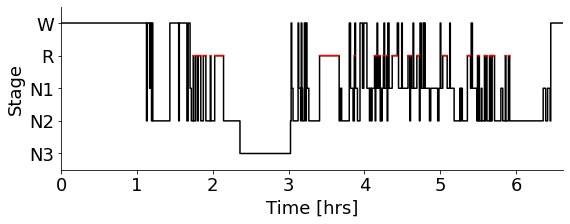

In [105]:
sls = yasa.SleepStaging(raw, eeg_name='C3-A2')
hypno_pred = sls.predict()  # Predict the sleep stages
hypno_pred = yasa.hypno_str_to_int(hypno_pred)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred);  # Plot